In Spot, automata edges are labeled by Boolean functions over atomic propositions.
As a consequence, it is sometimes difficult to adapt algorithms that expect automata labeled by letters.   This notebook presents methods that can be used to split those edge labels to make it easier to consider them as letters.

In [1]:
import spot
from spot.jupyter import display_inline
spot.setup(show_default=".A")

Consider the labels appearing in the following automaton:

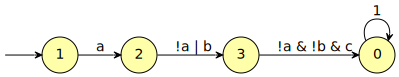

In [2]:
aut = spot.translate("a & X(a->b) & XX(!a&!b&c)")
aut

We try to use the word "edge" to refer to an edge of the automaton, labeled by a Boolean formula over AP.  These edges can be seen as representing several "transitions", each labeled by a valuation of all atomic propositions.  So the above automaton uses 4 edges to represent 19 transitions

In [3]:
s = spot.sub_stats_reachable(aut)
print(s.edges, s.transitions)

4 19


We can split the edges into the corresponding transitions using `split_edges()`.

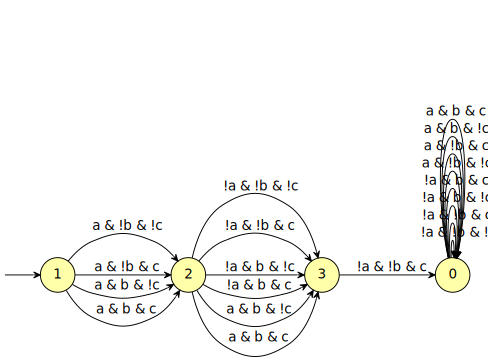

In [4]:
aut_split = spot.split_edges(aut)
aut_split

The opposite operation is `merge_edges()`, but it works in place:

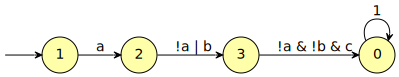

In [5]:
aut_split.merge_edges()
aut_split

Another way to split edges is `separate_edges()` this tweaks the labels so that any two labels can only be equal or disjoint.  Note how this creates fewer edges.

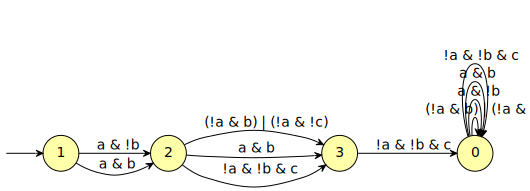

In [6]:
spot.separate_edges(aut)

A slightly lower-level interface is the `edge_separator` class.  This makes it possible to declare a "basis" (a set of labels) that will be used to separate the edge of an automaton.

`separate_edges()` is actually implemented as follows:

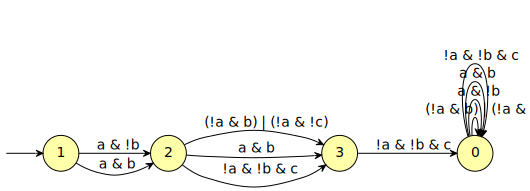

In [7]:
es = spot.edge_separator()
es.add_to_basis(aut)  # create a basis from the labels of aut
es.separate_implying(aut) # replace labels by all labels of the basis that imply them

The `edge_separator` can also be used to separate the edges of *another* automaton:

In [8]:
aut2 = spot.translate('a W Gd')
# replace labels based on "compatibility" with those from the basis
aut2sep = es.separate_compat(aut2)
display_inline(aut2, aut2sep)

Now, if we take any label A in `aut2sep` and any label B in `aut`, we necessarily 
have A∧B ∈ {A,0}.   I.e., either A implies B, or A and B are incompatible.  This is useful in certain algorithm that want to check that the inclusion of on automaton in another one, because they can arange to onlu check the inclusion (with `bdd_implies`) of the labels from the small automaton into the labels of the larger automaton.

We could also use `edge_separator` to create a combined basis for two automata:

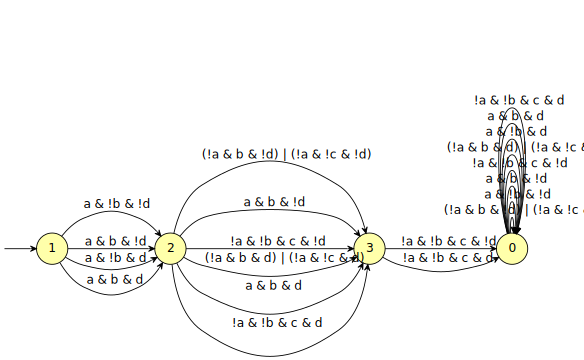

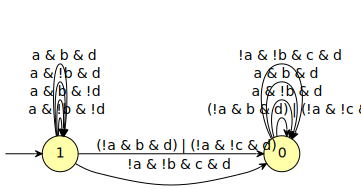

In [9]:
es2 = spot.edge_separator()
es2.add_to_basis(aut)
es2.add_to_basis(aut2)
display(es2.separate_implying(aut), es2.separate_implying(aut2))

A similar functionality can be achieved using the bdd_partition class

## BDD_PARTITION

This notebook demonstrates the usage of the class bdd_partition, which can be used to partition a set of conditions, which will be called original conditions. This is done by construction an 'implication forest', that is a forest in which:

    For every original condition there exists a corresponding root node
    Child nodes imply their parent nodes
    The disjunction over all children corresponds to the condition of the parent
    The set of leaf nodes form the partition

The interest is that each leaf condition behaves similar to a 'classical' letter, since these conditions do not overlap. This leads to (currently) two use-cases: The first is to split a transition into multiple transitions with conditions corresponding to leaves. The second is to relabel the automaton. That is to encode all leaves with minterms over freah APs, possibly reducing the number of APs necessary.


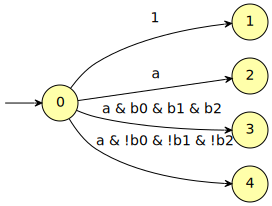

In [10]:
# Let us first construct a simple automaton to show case this
import buddy

aut = spot.make_twa_graph()
bdddict = aut.get_dict()

aut.new_states(5)

a = buddy.bdd_ithvar(aut.register_ap("a"))
na = buddy.bdd_nithvar(aut.register_ap("a"))
b0 = buddy.bdd_ithvar(aut.register_ap("b0"))
nb0 = buddy.bdd_nithvar(aut.register_ap("b0"))
b1 = buddy.bdd_ithvar(aut.register_ap("b1"))
nb1 = buddy.bdd_nithvar(aut.register_ap("b1"))
b2 = buddy.bdd_ithvar(aut.register_ap("b2"))
nb2 = buddy.bdd_nithvar(aut.register_ap("b2"))

cond1 = buddy.bddtrue
cond2 = a
cond3 = a&b0&b1&b2
cond4 = a&nb0&nb1&nb2
aut.new_edge(0, 1, cond1)
aut.new_edge(0, 2, cond2)
aut.new_edge(0, 3, cond3)
aut.new_edge(0, 4, cond4)

display(aut)

The partition is empty at first and is constructed iteratively when adding original conditions.

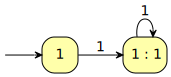

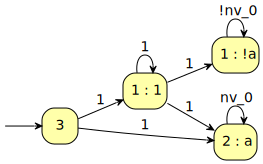

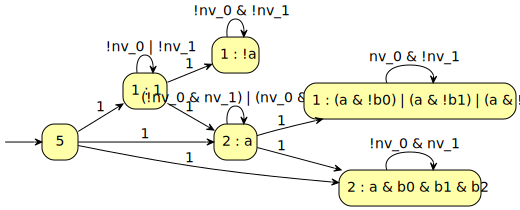

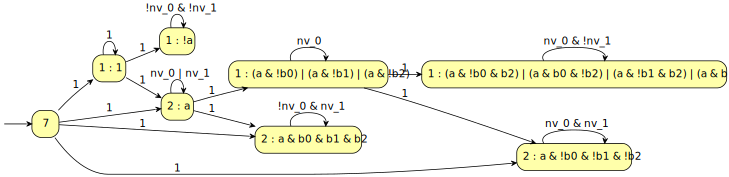

In [11]:
bddpart = spot.bdd_partition(bdddict)
for cond in [cond1, cond2, cond3, cond4]:
    bddpart.add_condition(cond)
    # To use or display the bdd_partition, we need to lock it
    # Locking takes no or two arguments: prefix (str) and sort (bool)
    # If prefix is non-empty, then the fresh AP used to encode the leaves will start with "prefix" followed by an id
    # If sort is set to true, child nodes appear in ascending order for any parent node
    bddpart.lock("nv_", False)
    # Conditions on transitions between nodes have no importance
    # Conditions on self-loops are the relabeled conditions over the fresh AP
    # State names are (how often a state is pointed to : the condition it represents)
    # To indicate root nodes, we add an artificial intial state and connect it to
    # all root nodes
    display(spot.automaton(bddpart.to_str("hoa")))
    # To add more conditions, we need to unlock
    bddpart.unlock()

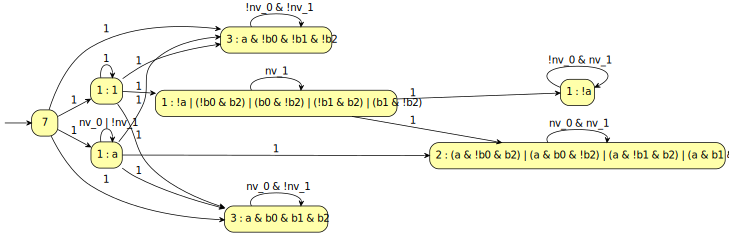

In [12]:
# The shape of the implication graph may change depending on the order in which the original conditions are added, 
# the partition itself remains the same
bddpart.reset()
for cond in [cond4, cond3, cond1, cond2]:
    bddpart.add_condition(cond)
bddpart.lock("nv_", False)
display(spot.automaton(bddpart.to_str("hoa")))
bddpart.unlock()

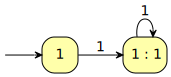

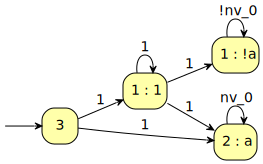

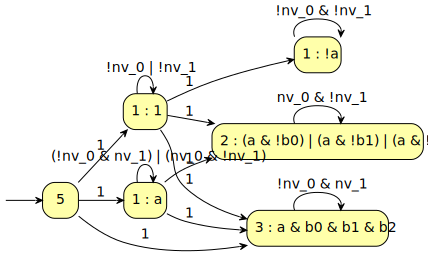

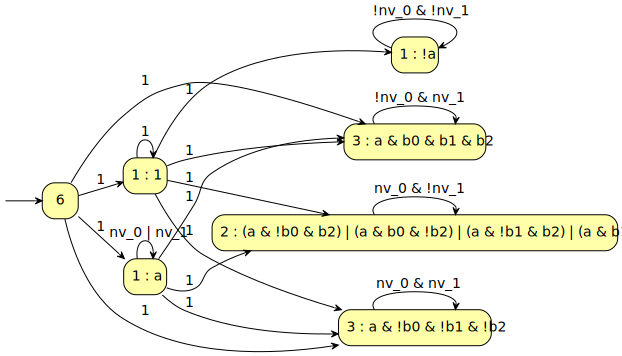

In [13]:
# When sorting is enabled, the implication graph will be flattened each time, it will have at most a height of one
# Resetting and adding the conditions once more
bddpart.reset()
for cond in [cond1, cond2, cond3, cond4]:
    bddpart.add_condition(cond)
    # If prefix is none-empty, the children are sorted with respect to the label over the fresh APs
    # else the original label is used for compairison
    bddpart.lock("nv_", True)
    display(spot.automaton(bddpart.to_str("hoa")))
    bddpart.unlock()

### Splitting and relabeling with bdd_partition

Once the bdd_partition is constructed we can use it to split or relabel an automaton.

In [14]:
# Construct a bdd_partition for all conditions
bddpart.reset()
for cond in [cond1, cond2, cond3, cond4]:
    bddpart.add_condition(cond)
# Lock with sorting, no relabeling
bddpart.lock("", True)

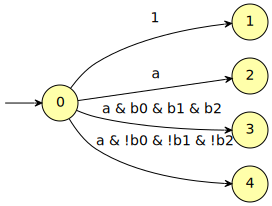

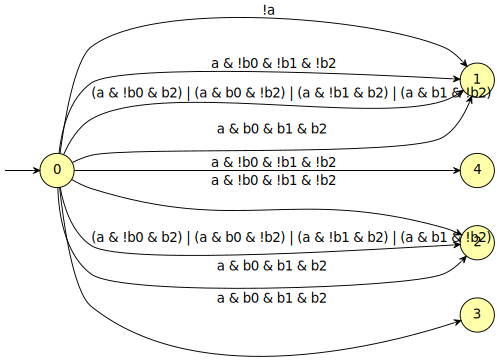

In [15]:
# Use it to seperate edges into conditions which are part of the partition
aut2 = spot.make_twa_graph(aut, spot.twa_prop_set.all())
display(aut2)
bddpart.separate_edges_here(aut2)
aut2

In [16]:
# As we set sort to true when locking, the edges are now sorted:
bddcomp = spot.bdd_less_than_stable()
for s in range(aut2.num_states()):
    last_cond = None
    for e in aut2.out(s):
        assert last_cond is None or last_cond == e.cond or bddcomp(last_cond, e.cond)
        last_cond = e.cond

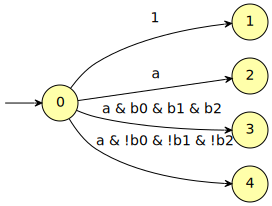

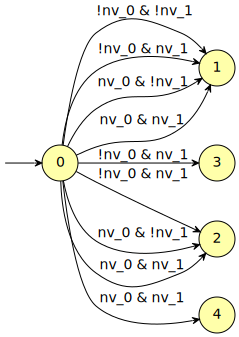

In [17]:
# Use it for relabelling
bddpart.unlock()
bddpart.lock("nv_", True)
aut2 = spot.make_twa_graph(aut, spot.twa_prop_set.all())
display(aut2)
bddpart.relabel_edges_here(aut2, True) # Second arg is whether to keep them split
aut2

In [18]:
# Still sorted, now with respect to the new conditions
bddcomp = spot.bdd_less_than_stable()
for s in range(aut2.num_states()):
    last_cond = None
    for e in aut2.out(s):
        assert last_cond is None or last_cond == e.cond or bddcomp(last_cond, e.cond)
        last_cond = e.cond

The above has shown the "manual" use of bdd_partition. To relabel an automaton or a game, see partitioned_relabel_here (spot/twaalgos/relabel.hh) and partitioned_game_relabel_here (spot/twaalgos/synthesis.hh)